<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [177]:
# Ucitavanje skupa podataka

data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data = data.dropna()
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)
data = data.loc[data['Date'] > pd.to_datetime('2021-01-28')]
data.head(4)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4769536,1611878400,33488.66,33511.60,33466.63,33466.63,3.680964,123253.27055,33483.968039,2021-01-29
4769537,1611878460,33462.73,33604.79,33435.24,33596.50,13.756321,461774.39554,33568.161717,2021-01-29
4769538,1611878520,33566.89,33662.45,33566.89,33636.53,12.618299,424345.02877,33629.337533,2021-01-29
4769539,1611878580,33655.74,33701.33,33637.28,33667.37,20.345956,685016.35953,33668.428338,2021-01-29


In [136]:
data.shape

(87724, 9)

In [137]:
#group = data.groupby('Date')
#mean_price = group['Weighted_Price'].mean()

In [179]:
def data_split(data, test_size = 0, days_to_predict = 0):

  if test_size == 0 and days_to_predict == 0:
    print('Uneti vrednost za jedan od parametara test_size ili days_to_predict.\n')
    return
  elif test_size == 0: # dato je days_to_predict
    test_limit = len(data) - prediction_days # TODO TODO TODO Da li sme data ili kolona?
  else: # dato je test_size ili oba parametra
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  return train, test

In [180]:
train, test = data_split(data, test_size = 0.2, days_to_predict = 0)

In [140]:
train.shape, test.shape

((70180, 9), (17544, 9))

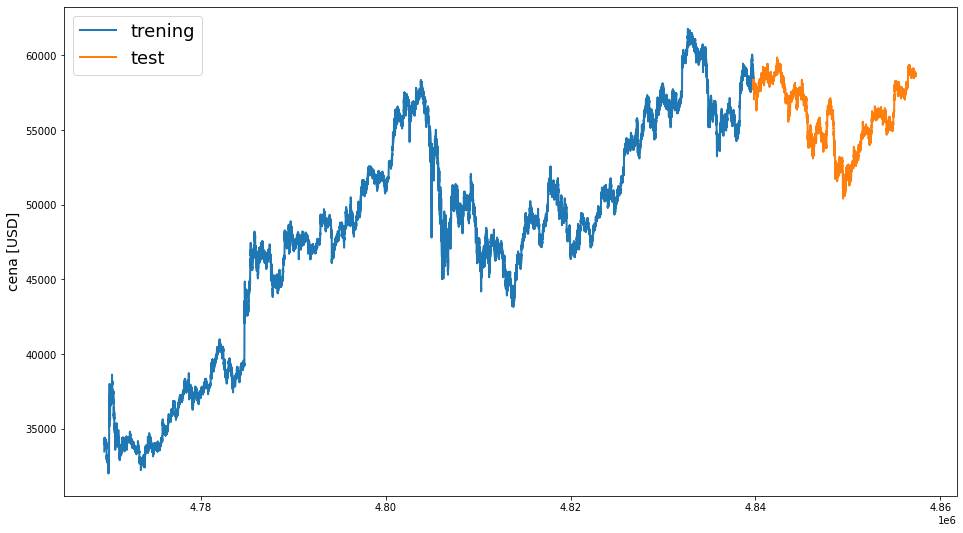

In [181]:
fig, ax = plt.subplots(1, figsize=(16, 9))

#plt.figure(figsize=(15,9), dpi=100, facecolor='w', edgecolor='k')
#ax = plt.gca()

ax.plot(train['Close'], label='trening', linewidth=2)
ax.plot(test['Close'], label='test', linewidth=2)
ax.set_ylabel('cena [USD]', fontsize=14)
#ax.set_title(title = 'BTC', fontsize=18)
ax.legend(loc='best', fontsize=18)

In [142]:
train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Open,High,Low,Close
4769536,33488.66,33511.60,33466.63,33466.63
4769537,33462.73,33604.79,33435.24,33596.50
4769538,33566.89,33662.45,33566.89,33636.53
4769539,33655.74,33701.33,33637.28,33667.37
4769540,33690.78,33782.29,33674.85,33767.33


In [143]:
train.shape, train_.shape

((70180, 9), (70180, 4))

In [145]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
train_ = scaler.fit_transform(train_)
#train_ = np.reshape(train_, (train_.shape[0], 1))
train_

array([[0.05033526, 0.04979255, 0.04974573, 0.04956498],
       [0.04946436, 0.05292481, 0.04868825, 0.05392423],
       [0.05296276, 0.05486286, 0.05312336, 0.05526789],
       ...,
       [0.87851268, 0.87780909, 0.87696148, 0.87392403],
       [0.87465086, 0.87824133, 0.87711342, 0.87682282],
       [0.87704897, 0.87859963, 0.878938  , 0.87800099]])

In [146]:
X_train = []
y_train = []

for i in range(60, train_.shape[0]):
    X_train.append(train_[i-60:i])
    y_train.append(train_[i,0])

In [147]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [148]:
X_train.shape

(70120, 60, 4)

In [151]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units =1))
regressor.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 60, 50)            11000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 60, 60)            26640     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 60)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 60, 80)            45120     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 80)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 120)             

In [152]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
history = regressor.fit(X_train, y_train, epochs = 20, batch_size =50)

Epoch 1/20
1403/1403 [==============================] - 411s 217ms/step - loss: 0.0181 - accuracy: 7.9283e-06
Epoch 2/20
1403/1403 [==============================] - 306s 218ms/step - loss: 0.0027 - accuracy: 1.6652e-05
Epoch 3/20
1403/1403 [==============================] - 304s 217ms/step - loss: 0.0015 - accuracy: 4.7361e-05
Epoch 4/20
1403/1403 [==============================] - 305s 217ms/step - loss: 0.0014 - accuracy: 1.3304e-05
Epoch 5/20
1403/1403 [==============================] - 305s 217ms/step - loss: 0.0014 - accuracy: 2.0051e-05
Epoch 6/20
1403/1403 [==============================] - 307s 219ms/step - loss: 0.0013 - accuracy: 6.5894e-05
Epoch 7/20
1403/1403 [==============================] - 299s 213ms/step - loss: 0.0013 - accuracy: 2.2123e-05
Epoch 8/20
1403/1403 [==============================] - 303s 216ms/step - loss: 0.0013 - accuracy: 3.4015e-05
Epoch 9/20
1403/1403 [==============================] - 308s 220ms/step - loss: 0.0013 - accuracy: 4.0584e-05
Epoch 10/2

In [166]:
test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)


# Skaliranje test skupa

test_ = scaler.transform(test_)
#train_ = np.reshape(train_, (train_.shape[0], 1))


X_test = []
y_test = []

for i in range(60, test_.shape[0]):
    X_test.append(test_[i-60:i])
    y_test.append(test_[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

y_predicted = regressor.predict(X_test)
y_predicted

array([[0.76599014],
       [0.76579905],
       [0.7654349 ],
       ...,
       [0.7915236 ],
       [0.7916178 ],
       [0.79172695]], dtype=float32)

In [171]:
test.shape

(17544, 11)

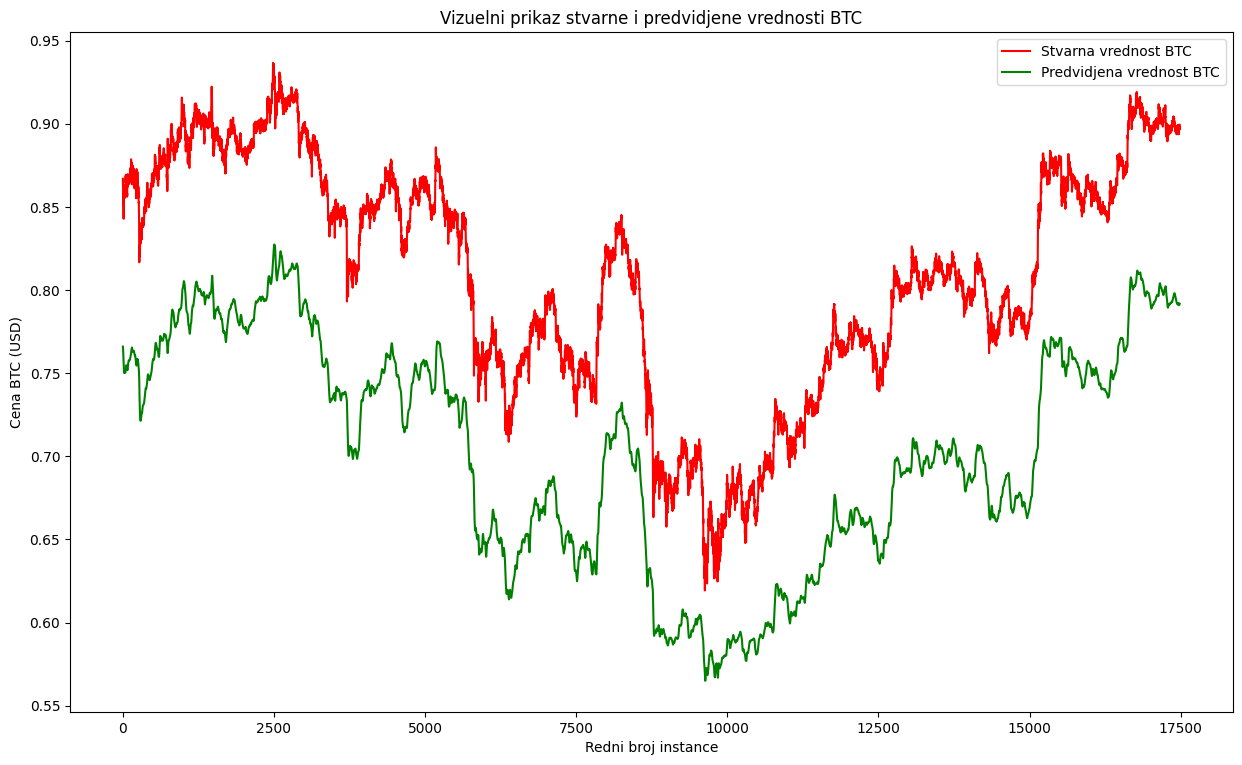

In [173]:
# Vizuelni prikaz rezultata modela mreze

plt.figure(figsize=(15,9), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.title('Vizuelni prikaz stvarne i predvidjene vrednosti BTC')
plt.plot(y_test, color = 'red', label = 'Stvarna vrednost BTC')
plt.plot(y_predicted, color = 'green', label = 'Predvidjena vrednost BTC')

#test = test.reset_index()
#x = test.index

#plt.xticks(x, labels = data[(len(data) - int(0.2 * len(data))):]['Date'], rotation = 'vertical')
plt.xlabel('Redni broj instance')
plt.ylabel('Cena BTC (USD)')
plt.legend(loc='best')
plt.show()

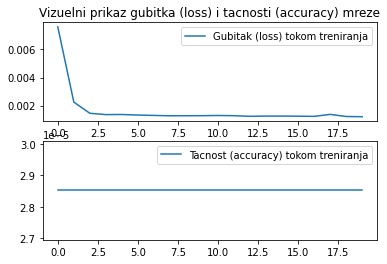

In [175]:
# Vizuelni prikaz gubitka (loss) tokom treniranja mreze

plt.subplot(211)
# plt.title('Gubitak (Loss)')
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], label='Gubitak (loss) tokom treniranja')
#plt.plot(epochs, history.history['val_loss'], label='Gubitak (val_loss) tokom validacije')

plt.legend()

plt.title('Vizuelni prikaz gubitka (loss) i tacnosti (accuracy) mreze')

# Vizuelni prikaz tacnosti (accuracy) tokom treniranja mreze

plt.subplot(212)
# plt.title('Tacnost (Accuracy)')
plt.plot(epochs, history.history['accuracy'], label='Tacnost (accuracy) tokom treniranja')
#plt.plot(epochs, history.history['val_accuracy'], label='Tacnost (val_accuracy) tokom validacije')

plt.legend()

plt.show()